In [1]:
import torch
import torch.nn as nn
from torch.func import jacrev, jacfwd, vmap

import numpy as np
import matplotlib.pyplot as plt # need 3.10 plus for "berlin" cmap
import matplotlib.colors as mcolors

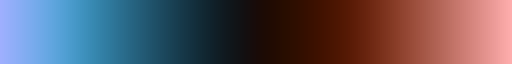

In [2]:
# Generate Berlin colormap although it is only available in Matplotlib 3.10
# print(matplotlib.__version__)

_berlin_data = [
    [0.62108, 0.69018, 0.99951],
    [0.61216, 0.68923, 0.99537],
    [0.6032, 0.68825, 0.99124],
    [0.5942, 0.68726, 0.98709],
    [0.58517, 0.68625, 0.98292],
    [0.57609, 0.68522, 0.97873],
    [0.56696, 0.68417, 0.97452],
    [0.55779, 0.6831, 0.97029],
    [0.54859, 0.68199, 0.96602],
    [0.53933, 0.68086, 0.9617],
    [0.53003, 0.67969, 0.95735],
    [0.52069, 0.67848, 0.95294],
    [0.51129, 0.67723, 0.94847],
    [0.50186, 0.67591, 0.94392],
    [0.49237, 0.67453, 0.9393],
    [0.48283, 0.67308, 0.93457],
    [0.47324, 0.67153, 0.92975],
    [0.46361, 0.6699, 0.92481],
    [0.45393, 0.66815, 0.91974],
    [0.44421, 0.66628, 0.91452],
    [0.43444, 0.66427, 0.90914],
    [0.42465, 0.66212, 0.90359],
    [0.41482, 0.65979, 0.89785],
    [0.40498, 0.65729, 0.89191],
    [0.39514, 0.65458, 0.88575],
    [0.3853, 0.65167, 0.87937],
    [0.37549, 0.64854, 0.87276],
    [0.36574, 0.64516, 0.8659],
    [0.35606, 0.64155, 0.8588],
    [0.34645, 0.63769, 0.85145],
    [0.33698, 0.63357, 0.84386],
    [0.32764, 0.62919, 0.83602],
    [0.31849, 0.62455, 0.82794],
    [0.30954, 0.61966, 0.81963],
    [0.30078, 0.6145, 0.81111],
    [0.29231, 0.60911, 0.80238],
    [0.2841, 0.60348, 0.79347],
    [0.27621, 0.59763, 0.78439],
    [0.26859, 0.59158, 0.77514],
    [0.26131, 0.58534, 0.76578],
    [0.25437, 0.57891, 0.7563],
    [0.24775, 0.57233, 0.74672],
    [0.24146, 0.5656, 0.73707],
    [0.23552, 0.55875, 0.72735],
    [0.22984, 0.5518, 0.7176],
    [0.2245, 0.54475, 0.7078],
    [0.21948, 0.53763, 0.698],
    [0.21469, 0.53043, 0.68819],
    [0.21017, 0.52319, 0.67838],
    [0.20589, 0.5159, 0.66858],
    [0.20177, 0.5086, 0.65879],
    [0.19788, 0.50126, 0.64903],
    [0.19417, 0.4939, 0.63929],
    [0.19056, 0.48654, 0.62957],
    [0.18711, 0.47918, 0.6199],
    [0.18375, 0.47183, 0.61024],
    [0.1805, 0.46447, 0.60062],
    [0.17737, 0.45712, 0.59104],
    [0.17426, 0.44979, 0.58148],
    [0.17122, 0.44247, 0.57197],
    [0.16824, 0.43517, 0.56249],
    [0.16529, 0.42788, 0.55302],
    [0.16244, 0.42061, 0.5436],
    [0.15954, 0.41337, 0.53421],
    [0.15674, 0.40615, 0.52486],
    [0.15391, 0.39893, 0.51552],
    [0.15112, 0.39176, 0.50623],
    [0.14835, 0.38459, 0.49697],
    [0.14564, 0.37746, 0.48775],
    [0.14288, 0.37034, 0.47854],
    [0.14014, 0.36326, 0.46939],
    [0.13747, 0.3562, 0.46024],
    [0.13478, 0.34916, 0.45115],
    [0.13208, 0.34215, 0.44209],
    [0.1294, 0.33517, 0.43304],
    [0.12674, 0.3282, 0.42404],
    [0.12409, 0.32126, 0.41507],
    [0.12146, 0.31435, 0.40614],
    [0.1189, 0.30746, 0.39723],
    [0.11632, 0.30061, 0.38838],
    [0.11373, 0.29378, 0.37955],
    [0.11119, 0.28698, 0.37075],
    [0.10861, 0.28022, 0.362],
    [0.10616, 0.2735, 0.35328],
    [0.10367, 0.26678, 0.34459],
    [0.10118, 0.26011, 0.33595],
    [0.098776, 0.25347, 0.32734],
    [0.096347, 0.24685, 0.31878],
    [0.094059, 0.24026, 0.31027],
    [0.091788, 0.23373, 0.30176],
    [0.089506, 0.22725, 0.29332],
    [0.087341, 0.2208, 0.28491],
    [0.085142, 0.21436, 0.27658],
    [0.083069, 0.20798, 0.26825],
    [0.081098, 0.20163, 0.25999],
    [0.07913, 0.19536, 0.25178],
    [0.077286, 0.18914, 0.24359],
    [0.075571, 0.18294, 0.2355],
    [0.073993, 0.17683, 0.22743],
    [0.07241, 0.17079, 0.21943],
    [0.071045, 0.1648, 0.2115],
    [0.069767, 0.1589, 0.20363],
    [0.068618, 0.15304, 0.19582],
    [0.06756, 0.14732, 0.18812],
    [0.066665, 0.14167, 0.18045],
    [0.065923, 0.13608, 0.17292],
    [0.065339, 0.1307, 0.16546],
    [0.064911, 0.12535, 0.15817],
    [0.064636, 0.12013, 0.15095],
    [0.064517, 0.11507, 0.14389],
    [0.064554, 0.11022, 0.13696],
    [0.064749, 0.10543, 0.13023],
    [0.0651, 0.10085, 0.12357],
    [0.065383, 0.096469, 0.11717],
    [0.065574, 0.092338, 0.11101],
    [0.065892, 0.088201, 0.10498],
    [0.066388, 0.084134, 0.099288],
    [0.067108, 0.080051, 0.093829],
    [0.068193, 0.076099, 0.08847],
    [0.06972, 0.072283, 0.083025],
    [0.071639, 0.068654, 0.077544],
    [0.073978, 0.065058, 0.07211],
    [0.076596, 0.061657, 0.066651],
    [0.079637, 0.05855, 0.061133],
    [0.082963, 0.055666, 0.055745],
    [0.086537, 0.052997, 0.050336],
    [0.090315, 0.050699, 0.04504],
    [0.09426, 0.048753, 0.039773],
    [0.098319, 0.047041, 0.034683],
    [0.10246, 0.045624, 0.030074],
    [0.10673, 0.044705, 0.026012],
    [0.11099, 0.043972, 0.022379],
    [0.11524, 0.043596, 0.01915],
    [0.11955, 0.043567, 0.016299],
    [0.12381, 0.043861, 0.013797],
    [0.1281, 0.044459, 0.011588],
    [0.13232, 0.045229, 0.0095315],
    [0.13645, 0.046164, 0.0078947],
    [0.14063, 0.047374, 0.006502],
    [0.14488, 0.048634, 0.0053266],
    [0.14923, 0.049836, 0.0043455],
    [0.15369, 0.050997, 0.0035374],
    [0.15831, 0.05213, 0.0028824],
    [0.16301, 0.053218, 0.0023628],
    [0.16781, 0.05424, 0.0019629],
    [0.17274, 0.055172, 0.001669],
    [0.1778, 0.056018, 0.0014692],
    [0.18286, 0.05682, 0.0013401],
    [0.18806, 0.057574, 0.0012617],
    [0.19323, 0.058514, 0.0012261],
    [0.19846, 0.05955, 0.0012271],
    [0.20378, 0.060501, 0.0012601],
    [0.20909, 0.061486, 0.0013221],
    [0.21447, 0.06271, 0.0014116],
    [0.2199, 0.063823, 0.0015287],
    [0.22535, 0.065027, 0.0016748],
    [0.23086, 0.066297, 0.0018529],
    [0.23642, 0.067645, 0.0020675],
    [0.24202, 0.069092, 0.0023247],
    [0.24768, 0.070458, 0.0026319],
    [0.25339, 0.071986, 0.0029984],
    [0.25918, 0.07364, 0.003435],
    [0.265, 0.075237, 0.0039545],
    [0.27093, 0.076965, 0.004571],
    [0.27693, 0.078822, 0.0053006],
    [0.28302, 0.080819, 0.0061608],
    [0.2892, 0.082879, 0.0071713],
    [0.29547, 0.085075, 0.0083494],
    [0.30186, 0.08746, 0.0097258],
    [0.30839, 0.089912, 0.011455],
    [0.31502, 0.09253, 0.013324],
    [0.32181, 0.095392, 0.015413],
    [0.32874, 0.098396, 0.01778],
    [0.3358, 0.10158, 0.020449],
    [0.34304, 0.10498, 0.02344],
    [0.35041, 0.10864, 0.026771],
    [0.35795, 0.11256, 0.030456],
    [0.36563, 0.11666, 0.034571],
    [0.37347, 0.12097, 0.039115],
    [0.38146, 0.12561, 0.043693],
    [0.38958, 0.13046, 0.048471],
    [0.39785, 0.13547, 0.053136],
    [0.40622, 0.1408, 0.057848],
    [0.41469, 0.14627, 0.062715],
    [0.42323, 0.15198, 0.067685],
    [0.43184, 0.15791, 0.073044],
    [0.44044, 0.16403, 0.07862],
    [0.44909, 0.17027, 0.084644],
    [0.4577, 0.17667, 0.090869],
    [0.46631, 0.18321, 0.097335],
    [0.4749, 0.18989, 0.10406],
    [0.48342, 0.19668, 0.11104],
    [0.49191, 0.20352, 0.11819],
    [0.50032, 0.21043, 0.1255],
    [0.50869, 0.21742, 0.13298],
    [0.51698, 0.22443, 0.14062],
    [0.5252, 0.23154, 0.14835],
    [0.53335, 0.23862, 0.15626],
    [0.54144, 0.24575, 0.16423],
    [0.54948, 0.25292, 0.17226],
    [0.55746, 0.26009, 0.1804],
    [0.56538, 0.26726, 0.18864],
    [0.57327, 0.27446, 0.19692],
    [0.58111, 0.28167, 0.20524],
    [0.58892, 0.28889, 0.21362],
    [0.59672, 0.29611, 0.22205],
    [0.60448, 0.30335, 0.23053],
    [0.61223, 0.31062, 0.23905],
    [0.61998, 0.31787, 0.24762],
    [0.62771, 0.32513, 0.25619],
    [0.63544, 0.33244, 0.26481],
    [0.64317, 0.33975, 0.27349],
    [0.65092, 0.34706, 0.28218],
    [0.65866, 0.3544, 0.29089],
    [0.66642, 0.36175, 0.29964],
    [0.67419, 0.36912, 0.30842],
    [0.68198, 0.37652, 0.31722],
    [0.68978, 0.38392, 0.32604],
    [0.6976, 0.39135, 0.33493],
    [0.70543, 0.39879, 0.3438],
    [0.71329, 0.40627, 0.35272],
    [0.72116, 0.41376, 0.36166],
    [0.72905, 0.42126, 0.37062],
    [0.73697, 0.4288, 0.37962],
    [0.7449, 0.43635, 0.38864],
    [0.75285, 0.44392, 0.39768],
    [0.76083, 0.45151, 0.40675],
    [0.76882, 0.45912, 0.41584],
    [0.77684, 0.46676, 0.42496],
    [0.78488, 0.47441, 0.43409],
    [0.79293, 0.48208, 0.44327],
    [0.80101, 0.48976, 0.45246],
    [0.80911, 0.49749, 0.46167],
    [0.81722, 0.50521, 0.47091],
    [0.82536, 0.51296, 0.48017],
    [0.83352, 0.52073, 0.48945],
    [0.84169, 0.52853, 0.49876],
    [0.84988, 0.53634, 0.5081],
    [0.85809, 0.54416, 0.51745],
    [0.86632, 0.55201, 0.52683],
    [0.87457, 0.55988, 0.53622],
    [0.88283, 0.56776, 0.54564],
    [0.89111, 0.57567, 0.55508],
    [0.89941, 0.58358, 0.56455],
    [0.90772, 0.59153, 0.57404],
    [0.91603, 0.59949, 0.58355],
    [0.92437, 0.60747, 0.59309],
    [0.93271, 0.61546, 0.60265],
    [0.94108, 0.62348, 0.61223],
    [0.94945, 0.63151, 0.62183],
    [0.95783, 0.63956, 0.63147],
    [0.96622, 0.64763, 0.64111],
    [0.97462, 0.65572, 0.65079],
    [0.98303, 0.66382, 0.66049],
    [0.99145, 0.67194, 0.67022],
    [0.99987, 0.68007, 0.67995]]

from matplotlib.colors import ListedColormap

cmaps = {
    name: ListedColormap(data, name = name) for name, data in [
        ('berlin', _berlin_data),
    ]}

cmaps['berlin']

In [3]:
def set_seed(seed = 42):
    np.random.seed(seed)            # NumPy
    torch.manual_seed(seed)         # PyTorch CPU
    torch.cuda.manual_seed(seed)    # PyTorch GPU (single-GPU)

# Set seed before initializing the model
set_seed(42)

# Matrix field reconstruction

The **matrix field reconstruction** has one less Jacobian step than the **vector field reconstruction** which is why it is computationally more efficient.

We use the following deterministic transformations to get from the NN output to a divergence-free vector field v:
1. Parameterise the Skew-Symmetric decomposition of A
    - **U_topright = NN(x)** (non-zero values U_topright (N x 1) for the Upper Triangular U (N x dims x dims). For 2D, the dimensionality of U_topright is just 1, but generally it is (dims(dims - 1)/2)).
2. Construct anti-symmetric matrix A
    - **A = U - U.T**
3. Attain divergence-free vector field v via row-wise Jacobians
    - **v = (div(A[0,:]), div(A[1,:]))**, trace of the Jacobian

To check that this is divergence free we need another Jacobian.

see https://github.com/facebookresearch/neural-conservation-law/blob/main/pytorch/divfree.py

Dimensionalities:
- If our input in (4 x 4, 2) so flat that is (16, 2) coordinate pairs, U_topright should be (16, 1)

## Questions

- Do we use a NN that processes a batch or points individually? (Batch)
- What is the output shape of u_v?
    - For the dim = 2 case, do it is always (dim * (dim - 1) / 2), which is 1 because we only estimate the upper right corner of every (N) 2 x 2 matrix
    - Can we build this directly into the net?

The model seems to only be implemented under [jax > models.py > Divfree()](https://github.com/facebookresearch/neural-conservation-law/blob/20a403d00affad905d1c47b041bc60d0ff0ea360/jax/models.py#L118). DivfreeSparse() and DivFreeImplicit() are not used anywhere.

The model is used in [jax > hh_experiment_DivFree.py](https://github.com/facebookresearch/neural-conservation-law/blob/20a403d00affad905d1c47b041bc60d0ff0ea360/jax/hh_experiment_DivFree.py#L53). Hodge decomp.

dim = 10.  
mlp = MLP(depth = layers, width = width, act = act, out_dim = **dim * (dim-1) // 2**, std = 1, bias = True)

For dim = 2, at each point, each matrix A (2 x 2) is antisymm. So we only have to estimate a scalar for each input point.

u_fn, params, _ = build_divfree_vector_field(self.module)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim = 2, hidden_dim = 32):
        super().__init__()
        
        output_dim = int((input_dim * (input_dim - 1)) / 2)
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # put deterministic transformations here with torch functional
        return self.net(x)  # Output shape: (4,)

In [4]:
class MLP_compute_A(nn.Module):
    def __init__(self, input_dim = 2, hidden_dim = 32):
        super().__init__()

        self.input_dim = input_dim
        
        # Output dim follows input dims
        # for 2D input the NN output dim is 1
        self.output_dim = int((input_dim * (input_dim - 1)) / 2)

        # Replace with something more sophisticated
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )

    def forward(self, x):
        # put deterministic transformations here with torch functional

        # RUN THROUGH NET
        U_fill = self.net(x)

        # Extract dims
        N = int(x.shape[0])
        
        # This version works with vmap, diagonal shifts diagional one up
        U_zero_one = torch.triu(torch.ones(N, self.input_dim, self.input_dim), diagonal = 1)

        # U_zero_one is (N, 2, 2), U_fill is (N, 1), so we need to unsqueeze the first dim of U_fill
        U = U_zero_one * U_fill.unsqueeze(1)

        # U is (N, 2, 2), so we need to swap the last two dims and then subtract
        A = U - U.transpose(1, 2)

        return A  # Output shape: (N, 2, 2)

# Small example

In [ ]:
# 4 x 4 grid
N = 16  # N should be a perfect square
N_side = int(N ** 0.5)

dims = 2

# inputs = torch.randn(N, dims)  # Random (N, 2) inputs
xy_side = torch.linspace(0, 1, N_side)
# torch meshgrid, not default but we want to index by x, y
X_mesh, Y_mesh = torch.meshgrid(xy_side, xy_side, indexing = "xy")
# Construct flat pairs of points
inputs = torch.cat([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)], dim = 1)
print(inputs.shape)

torch.Size([16, 2])


In [5]:
# overwrite with 20 * 20 grid
N = 20 * 20 # N should be a perfect square
N_side = int(N ** 0.5)

dims = 2

# inputs = torch.randn(N, dims)  # Random (N, 2) inputs
xy_side = torch.linspace(0, 3, N_side)
# torch meshgrid, not default but we want to index by x, y
X_mesh, Y_mesh = torch.meshgrid(xy_side, xy_side, indexing = "xy")

# Construct flat pairs of points
# now the span [0, 3]
inputs_03 = torch.cat([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)], dim = 1)
print(inputs_03.shape)

torch.Size([400, 2])


In [ ]:
# write this as a function because we need to input a function for the Jacobian calculation
def compute_A(x, model_for_A):
    # U_fill is (N, 1), which is the model output, fills upper right corner of all 2x2 matrices
    U_fill = model_for_A(x)
    # Extract N 
    N = int(x.shape[0])

    # This version works with vmap, diagonal shifts diagional one up
    U_zero_one = torch.triu(torch.ones(N, dims, dims), diagonal = 1)
    # U_zero_one is (N, 2, 2), U_fill is (N, 1), so we need to unsqueeze the first dim of U_fill
    U = U_zero_one * U_fill.unsqueeze(1)
    # result is the same as U[:, 0, 1] = U_fill.squeeze()
    # alternative might be torch.index_add
    # U is (N, 2, 2), so we need to swap the last two dims and then subtract
    A = U - U.transpose(1, 2)
    return A

In [ ]:
def compute_v(x, model_for_A):
    # Compute the Jacobian of A 
    jacobian_A = vmap(jacfwd(model_for_A))(x)
    # assert that the second dim (size N) is redundant
    assert(jacobian_A[:, 0, : , :, :] == jacobian_A[:, -1, : , :, :]).any()
    # remove this redundant dimension
    jacobian_A_lean = jacobian_A[:, 0, : , :, :]
    # print(jacobian_A_lean.shape): torch.Size([N, 2, 2, 2])
    # dim1 is what is considered the rows, dim2 is what is considered the columns
    # So we compute this over the last two dims because the Jacobian is N x two (2 x 2)
    v = torch.diagonal(jacobian_A_lean, dim1 = -2, dim2 = -1).sum(dim = 1)
    # diagonal returns torch.Size([16, 2, 2]) so now we sum over the middle dim
    return v

In [9]:
def div_functional(x):
    # print(jacobian_v.shape): torch.Size([16, 16, 2, 2])
    jacobian_v = vmap(jacfwd(compute_v))(x)
    print(jacobian_v.shape)
    # assert that the second dim (size N) is redundant
    assert(jacobian_v[:, 0, :, :] == jacobian_v[:, -1, :, :]).any()
    # print(jacobian_v_lean.shape): torch.Size([16, 2, 2])
    jacobian_v_lean = jacobian_v[:, 0, :, :]
    # torch.Size([16, 2]) and then we sum over the last dim to combine div_x and div_y
    # attain flat divergence field 
    div_flat = torch.diagonal(jacobian_v_lean, dim1 = -2, dim2 = -1).sum(dim = -1)
    return div_flat

# div_v = div_functional(inputs)

In [150]:
div_functional(inputs_03)

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [10]:
def visualise_v_stream(v, div_v, x, title_string = "v(x)", color_abs_max = 0.5, lw_scalar = 2):
    """Plots a vector field v(x) and its divergence div_v(x) as a streamplot on a square grid.
    The linewidth corresponds to the magnitude/speed of the vector field.
    The color corresponds to the divergence of the vector field. We use the dark doiverging colormap "berlin" so that zero divergence is visible as black. 

    Args:
        v (torch.Size([N_long, 2])): flattened square vector field, where the first column is the u component and the second column is the v component
        div_v (torch.Size([N_long])): flat divergence of the vector field
        x (torch.Size([N_long, 2])): flattend meshgrids, where the first column is the x component and the second column is the y component
        title_string (str, optional): Title for plot. Defaults to "v(x)".
        color_abs_max (float, optional): Maximum absolute value for color normalization. Defaults to 0.5.
    """

    # Extract N_long and calculate sqrt of N_long, N_side
    N_long = torch.tensor(v.shape[0])
    N_side = int(torch.sqrt(N_long))

    # Extract both columns/components from v and make square
    U = v[:, 0].reshape(N_side, N_side)
    V = v[:, 1].reshape(N_side, N_side)

    # Make coordinates square again
    X = x[:, 0].reshape(N_side, N_side)
    Y = x[:, 1].reshape(N_side, N_side)

    div_v_square = div_v.reshape(N_side, N_side)
    # Define symmetric normalization with zero centered
    norm = mcolors.TwoSlopeNorm(vmin = - color_abs_max, vcenter = 0, vmax = color_abs_max)

    # Magnitude i.e. speed: square each element to remove negative direction, then square root
    mag = torch.sqrt(torch.square(U) + torch.square(V))
    lw = mag * lw_scalar / torch.max(mag) # normalise mag

    fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    ax.streamplot(X.numpy(), Y.numpy(), U.numpy(), V.numpy(), 
                  linewidth = lw.numpy(),
                  color = div_v_square.numpy(), 
                  cmap = cmaps['berlin'],
                  norm = norm)
    
    # coolwarm is diverging but has grey in middle
    # add norm
    ax.set_aspect(1)
    ax.set_title(title_string)

    plt.show()

In [11]:
def visualise_v_quiver(v, div_v, x, title_string = "v(x)", color_abs_max = 0.5, lw_scalar = 2):
    """Plots a vector field v(x) and its divergence div_v(x) as a quiverplot on a square grid.
    The quiverlength automatically corresponds to the magnitude/speed of the vector field.
    The color corresponds to the divergence of the vector field. We use the dark diverging colormap "berlin" so that zero divergence is visible as black. 

    Args:
        v (torch.Size([N_long, 2])): flattened square vector field, where the first column is the u component and the second column is the v component
        div_v (torch.Size([N_long])): flat divergence of the vector field
        x (torch.Size([N_long, 2])): flattend meshgrids, where the first column is the x component and the second column is the y component
        title_string (str, optional): Title for plot. Defaults to "v(x)".
        color_abs_max (float, optional): Maximum absolute value for color normalization. Defaults to 0.5.
    """

    # Extract N_long and calculate sqrt of N_long, N_side
    N_long = torch.tensor(v.shape[0])
    N_side = int(torch.sqrt(N_long))

    # Extract both columns/components from v and make square
    U = v[:, 0].reshape(N_side, N_side)
    V = v[:, 1].reshape(N_side, N_side)

    # Make coordinates square again
    X = x[:, 0].reshape(N_side, N_side)
    Y = x[:, 1].reshape(N_side, N_side)

    div_v_square = div_v.reshape(N_side, N_side)
    # Define symmetric normalization with zero centered
    norm = mcolors.TwoSlopeNorm(vmin = - color_abs_max, vcenter = 0, vmax = color_abs_max)

    # Magnitude i.e. speed: square each element to remove negative direction, then square root
    # mag = torch.sqrt(torch.square(U) + torch.square(V))
    # lw = mag * lw_scalar / torch.max(mag) # normalise mag

    fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    ax.quiver(X.numpy(), Y.numpy(), U.numpy(), V.numpy(),
              div_v_square.numpy(), # color is passed directly
              cmap = cmaps['berlin'],
              norm = norm)

    # ax.quiver(x[:, 0], x[:, 1], v[:, 0], v[:, 1])
    
    # coolwarm is diverging but has grey in middle
    # add norm
    ax.set_aspect(1)
    ax.set_title(title_string)

    plt.show()

In [12]:
v = compute_v(inputs)
div_v = div_functional(inputs)

visualise_v_stream(v.detach(), div_v.detach(), inputs, title_string = "v(x)", color_abs_max = 0.5)

NameError: name 'model_A' is not defined

In [13]:
def div_discrete(v_flat_grid, dx = 1, dy = 1, return_components_bool = False):
    """Compute
    div(v) = dU/dx + dV/dy
    where v = (U, V) is a vector field
    edges can be funky

    Args:
        v_flat_grid (torch.Size([N, 2])): flattened vector field
        dx (int, optional): unit spacing between x columns. Defaults to 1.
        dy (int, optional): unit spacing between y rows. Defaults to 1.

    Returns:
        div_v (torch.Size([N, 1])): Same extent as v input, but only 1 dim, torch tensor for consistency
    OR Returns:
        div_v (torch.Size([N, 1])): Same extent as v input, but only 1 dim
        dU_dx (torch.Size([N, 1])): x derivative of U component
        dV_dy (torch.Size([N, 1])): y derivative of V component
    """
    N_side = int(np.sqrt(v_flat_grid.shape[0]))
    v_square = v_flat_grid.reshape(N_side, N_side, 2)

    U = v_square[:, :, 0]
    V = v_square[:, :, 1]

    # Compute the x and y derivatives
    dU_dx = np.gradient(U, dx, axis = 1) # axis 1 is x
    dV_dy = np.gradient(V, dy, axis = 0) # axis 0 is y

    # Compute the divergence
    div_v = dU_dx + dV_dy

    if return_components_bool == True:
        return torch.tensor(div_v).reshape(-1, 1), torch.tensor(dU_dx).reshape(-1, 1), torch.tensor(dV_dy).reshape(-1, 1)
    else:
        return torch.tensor(div_v).reshape(-1, 1)

In [14]:
v = simulate_convergence(inputs_03)
div_v = div_discrete(v)

visualise_v_quiver(v, div_v, inputs_03, title_string = "v(x)", color_abs_max = 0.5)

NameError: name 'simulate_convergence' is not defined

# Compare Jacobian

In [73]:
model_A = MLP_compute_A()
model_A.train()

# fixed_value = 0.5  # Change this to your desired fixed value

# with torch.no_grad():  # Ensure we don't track gradients
#    for param in model_A.parameters():
#        param.fill_(fixed_value)  # Set all elements to fixed_value


x = torch.tensor([[0.0, 0.5], [1.0, 0.8], [2.0, 2.0], [3.0, 3.0]]).requires_grad_()
A = model_A(x)
A

tensor([[[ 0.0000, -0.1466],
         [ 0.1466,  0.0000]],

        [[ 0.0000, -0.2350],
         [ 0.2350,  0.0000]],

        [[ 0.0000, -0.4260],
         [ 0.4260,  0.0000]],

        [[ 0.0000, -0.6009],
         [ 0.6009,  0.0000]]], grad_fn=<SubBackward0>)

torch.autograd.functional.jacobian: 

For the N's it seems we have to use pairwise indices: 0, 0, 1, 1, 

In [ ]:
jacobian_A_autograd = torch.autograd.functional.jacobian(model_A, x)

print(jacobian_A_autograd.shape)
n_i = 2
print(jacobian_A_autograd[n_i, :, :, n_i, :])

jacobian_A_autograd_lean = torch.einsum('nabnc -> nabc', jacobian_A_autograd)
print(jacobian_A_autograd_lean.shape)

jacobian_A_autograd_lean.diagonal(dim1 = -2, dim2 = -1).sum(dim = 1)

torch.Size([4, 2, 2, 4, 2])


tensor([[-0.0110, -0.0779],
        [ 0.1238, -0.0442],
        [ 0.1249, -0.0522],
        [ 0.1226, -0.0511]])

In [137]:
jacobian_A_vmap_jacrev = vmap(jacrev(model_A))(x)
# assert that the second dim (size 2) is redundant
assert(jacobian_A_vmap_jacrev[:, 0, :, :, :] == jacobian_A_vmap_jacrev[:, 1, :, :, :]).any()
jacobian_A_vmap_jacrev_lean = torch.einsum('n r a b c -> n a b c', jacobian_A_vmap_jacrev)

print(jacobian_A_vmap_jacrev_lean.shape)

jacobian_A_vmap_jacrev_lean.diagonal(dim1 = -2, dim2 = -1).sum(dim = 1)

torch.Size([4, 2, 2, 2])


tensor([[-0.0642,  0.1081],
        [ 0.0055,  0.2341],
        [ 0.0249,  0.2973],
        [ 0.0266,  0.3012]], grad_fn=<SumBackward1>)

In [115]:
jacobian_A_vmap_jacrev[0]

tensor([[[[ 0.0000,  0.0000],
          [ 0.0321,  0.0540]],

         [[-0.0321, -0.0540],
          [ 0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000],
          [ 0.0321,  0.0540]],

         [[-0.0321, -0.0540],
          [ 0.0000,  0.0000]]]], grad_fn=<SelectBackward0>)

In [ ]:
jacobian_A_vmap_jacrev[0, 0, :, :, :]
jacobian_A_vmap_jacrev[1, 0, :, :, :]

tolerance = 1e-6  # Adjust based on precision needs
assert torch.allclose(jacobian_A_vmap_jacrev[:, 1, :, :, :], jacobian_A_vmap_jacrev[:, 0, :, :, :], atol = tolerance)

AssertionError: 

# Training

In [15]:
from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [16]:
# float32 is default for
# x_train = torch.load("data/sim_data/x_train_lines_discretised.pt").float().requires_grad_()
x_train = inputs_03
y_train = simulate_convergence(x_train).float()

print(f"The shape of the training data is {y_train.shape}.")
print(f"The dtype of the input data is {x_train.dtype}.")

# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise model
model_A = MLP_compute_A()
model_A.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(model_A.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 3000

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()
        
        ### VMAP JACREF/JACFWRD Workflow ###
        # 1 min on CPU
        # torch.Size([N, 2, 2, 2, 2])
        # jacobian_A_vmap_jacrev = vmap(jacrev(model_A))(x_batch)
        # assert that the second dim (size 2) is redundant ("r)")
        # assert(jacobian_A_vmap_jacrev[:, 0, :, :, :] == jacobian_A_vmap_jacrev[:, 1, :, :, :]).all()
        # jacobian_A_vmap_jacrev_lean = torch.einsum('n r a b c -> n a b c', jacobian_A_vmap_jacrev)
        #y_pred = jacobian_A_vmap_jacrev_lean.diagonal(dim1 = -2, dim2 = -1).sum(dim = 1)

        ### AUTOGRAD Workflow ###
        # 7 minutes on CPU
        # torch.Size([N, 2, 2, N, 2])
        jacobian_A_autograd = torch.autograd.functional.jacobian(model_A, x_batch, create_graph = True)
        # select pairs of n_i and n_i (the rest is empty)
        jacobian_A_autograd_lean = torch.einsum('nabnc -> nabc', jacobian_A_autograd)
        # The last two dims, and then we sum
        y_pred = torch.diagonal(jacobian_A_autograd_lean, dim1 = -2, dim2 = -1).sum(dim = 1)

        # Compute loss
        loss = criterion(y_pred, y_batch)
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (MSE): {loss.item():.4f}")

The shape of the training data is torch.Size([400, 2]).
The dtype of the input data is torch.float32.

Start Training
Epoch 1/3000, Training Loss (MSE): 3.5045
Epoch 2/3000, Training Loss (MSE): 2.7653
Epoch 3/3000, Training Loss (MSE): 1.9253
Epoch 4/3000, Training Loss (MSE): 2.7459
Epoch 5/3000, Training Loss (MSE): 3.8651
Epoch 6/3000, Training Loss (MSE): 2.3756
Epoch 7/3000, Training Loss (MSE): 3.0656
Epoch 8/3000, Training Loss (MSE): 2.8001
Epoch 9/3000, Training Loss (MSE): 2.5379
Epoch 10/3000, Training Loss (MSE): 3.0449
Epoch 11/3000, Training Loss (MSE): 2.8821
Epoch 12/3000, Training Loss (MSE): 2.4246
Epoch 13/3000, Training Loss (MSE): 2.8064
Epoch 14/3000, Training Loss (MSE): 2.6566
Epoch 15/3000, Training Loss (MSE): 2.1046
Epoch 16/3000, Training Loss (MSE): 2.3914
Epoch 17/3000, Training Loss (MSE): 2.6622
Epoch 18/3000, Training Loss (MSE): 1.6066
Epoch 19/3000, Training Loss (MSE): 1.9638
Epoch 20/3000, Training Loss (MSE): 2.6218
Epoch 21/3000, Training Loss (M

KeyboardInterrupt: 

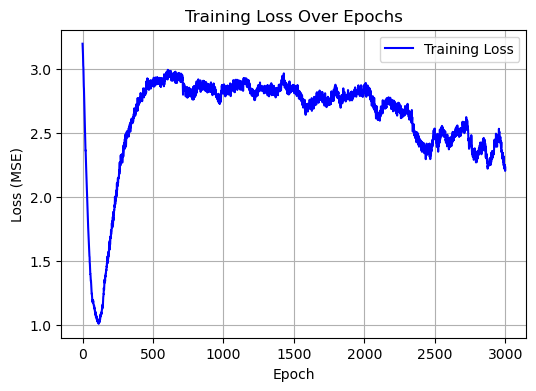

In [169]:
# Convert to NumPy for plotting
plt.figure(figsize = (6, 4))
plt.plot(epoch_losses.numpy(), label = "Training Loss", color = "b")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Try this with another Jacobian function

torch.autograd.functional.jacobian()
Need to "turn on" requires_grad for x because we are taking gradients with respect to it!

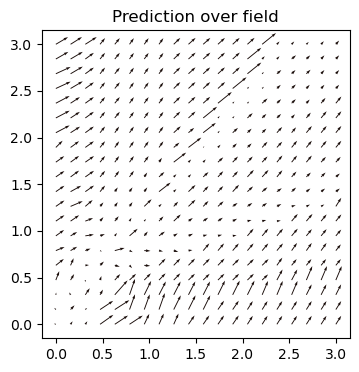

In [166]:
# Eval mode
model_A.eval()

x = inputs_03

### AUTOGRAD Workflow ###
# jacobian_A_autograd = torch.autograd.functional.jacobian(model_A, x)
# jacobian_A_autograd_lean = torch.einsum('nabnc -> nabc', jacobian_A_autograd)
# y_pred = torch.diagonal(jacobian_A_autograd_lean , dim1 = -2, dim2 = -1).sum(dim = 1).detach()

### VMAP JACREF/JACFWRD Workflow ###
jacobian_A_vmap_jacrev = vmap(jacrev(model_A))(x)
# assert that the second dim (size 2) is redundant ("r)")
assert(jacobian_A_vmap_jacrev[:, 0, :, :, :] == jacobian_A_vmap_jacrev[:, 1, :, :, :]).all()
jacobian_A_vmap_jacrev_lean = torch.einsum('n r a b c -> n a b c', jacobian_A_vmap_jacrev)
y_pred = jacobian_A_vmap_jacrev_lean.diagonal(dim1 = -2, dim2 = -1).sum(dim = 1)

# div_jacrav = div_functional(x)
div_jacrav = div_discrete(y_pred.detach())
div_jacrav = torch.zeros_like(div_jacrav)

visualise_v_quiver(y_pred.detach(), div_jacrav, x.detach(), title_string = "Prediction over field", color_abs_max = 0.2)

In [ ]:
visualise_v_quiver(simulate_convergence(inputs_03), div_functional(inputs_03), inputs_03, title_string = "Prediction over field", color_abs_max = 0.2)

In [ ]:
y_pred.detach().mean(dim = 0)

In [ ]:
simulate_convergence(inputs_03).detach().mean(dim = 0)

In [ ]:
y_train.mean(dim = 0)

In [ ]:
visualise_v_quiver(y_pred.detach(), div_functional(inputs_03), inputs_03, title_string = "Prediction over field", color_abs_max = 0.2)

In [ ]:
# Jacobian w.r.t. v throughs issues if x is a variable in compute_v

## Jacobian headache

- Jacobian is probably among the most expensive functions
- [torch.func.jacrev](https://pytorch.org/docs/stable/generated/torch.func.jacrev.html#torch.func.jacrev)
    - The implementation goes forward
    - torch.func.jacobian chooses based on efficiency
- batched Jacobians via vmap
- consider # _func_sum
- torch.autograd.functional.jacobian(f, x)
    - not as fast as func
- Shape torch.Size([16, 2, 2, 2])
    - for every i in N we have 2 (two) 2 x 2 matrices

In [ ]:
x = torch.randn(5, 2, 2)
jacobian_vmap = vmap(jacrev(torch.sin))(x)
print(jacobian_vmap.shape)

jacobian = jacrev(torch.sin)(x)
print(jacobian.shape)

In [ ]:
# Issue with how we construct U 
# Jacobian: torch.Size([16, 16, 2, 2, 2])
# without vmap it was also torch.Size([16, 2, 2, 16, 2])
jacobian = vmap(jacfwd(compute_A))(inputs)
print(jacobian.shape)

# Remove redundant dim
# (jacobian[:, 0, : , :, :] == jacobian[:, 15, : , :, :]).any()
assert(jacobian[:, 0, : , :, :] == jacobian[:, -1, : , :, :]).any()
#jacobian_sq = jacobian[:, 0, : , :, :]
#jacobian_sq.shape

# ToDo

Use apply function to pass arguments into function
jacobian_A_vmap_jacrev = vmap(lambda x: jacrev(model_A)(x, param))(x_batch)
